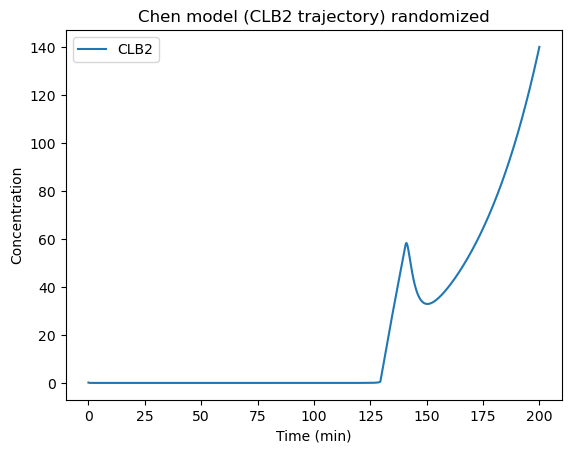

Sampled parameters (multipliers):
b0: 1.0
bub2h: 1.75
bub2l: 1.75
C0: 0.75
CDC15T: 2.0
Dn3: 1.25
ebudb5: 2.0
ebudn2: 2.0
ebudn3: 1.75
ec1b2: 0.5
ec1b5: 0.75
ec1k2: 0.5
ec1n2: 0.75
ec1n3: 0.75
ef6b2: 2.0
ef6b5: 0.25
ef6k2: 1.0
ef6n2: 1.5
ef6n3: 2.0
eicdhb2: 1.75
eicdhb5: 2.0
eicdhn2: 2.0
eicdhn3: 0.25
eorib2: 1.25
eorib5: 1.25
esbfb5: 1.25
esbfn2: 1.75
esbfn3: 1.0
ESP1T: 0.75
IET: 1.5
J20ppx: 1.5
Jacdh: 1.25
Jaiep: 1.75
Jamcm: 0.5
Jasbf: 0.25
Jatem: 1.25
Jd2c1: 0.25
Jd2f6: 1.25
Jicdh: 1.5
Jiiep: 0.25
Jimcm: 0.5
Jisbf: 1.5
Jitem: 2.0
Jn3: 1.5
Jpds: 0.75
Jspn: 0.5
ka15_p: 0.25
ka15_p_p: 0.25
ka15p: 2.0
ka20_p: 2.0
ka20_p_p: 2.0
kacdh_p: 1.0
kacdh_p_p: 0.5
kaiep: 1.0
kamcm: 0.25
kasb2: 1.0
kasb5: 0.5
kasbf: 1.25
kasesp: 0.5
kasf2: 2.0
kasf5: 1.75
kasrent: 1.25
kasrentp: 0.75
kaswi: 1.25
kd14: 0.25
kd1c1: 1.25
kd1f6: 0.25
kd1pds_p: 2.0
kd20: 1.25
kd2c1: 1.5
kd2f6: 0.75
kd2pds_p_p: 0.75
kd3c1: 0.5
kd3f6: 1.0
kd3pds_p_p: 2.0
kdb2_p: 2.0
kdb2_p_p: 0.75
kdb2p: 1.25
kdb5_p: 1.5
kdb5_p_p: 1.0
kdb

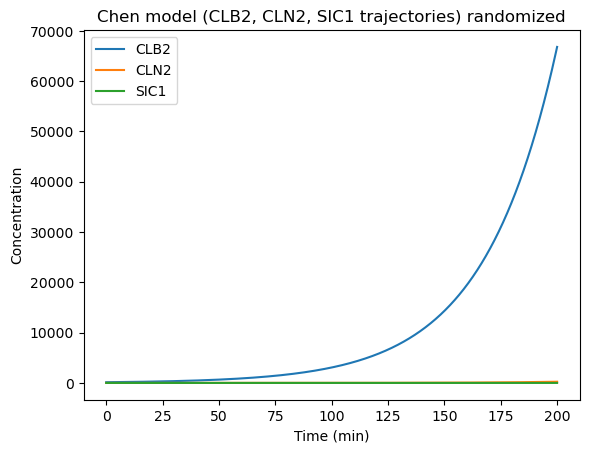

In [ ]:
import tellurium as te
import numpy as np
import matplotlib.pyplot as plt
import random

import roadrunner
import math

# Silence RoadRunner log messages completely
roadrunner.Logger.setLevel(roadrunner.Logger.LOG_CRITICAL)


# Load Chen 2004 budding yeast cell cycle model
rr = te.loadSBMLModel("/home/gijs/Documents/OxfordEvolution/Yeast/Chen/chen2004_biomd56.xml")
multipliers = [0.25, 0.50, 0.75, 1.00, 1.25, 1.50, 1.75, 2.00]

def sample_parameters(rr, wildtype=False):
    """Multiply only free global parameters by a random factor, or set all to 1 for wildtype."""
    sampled = {}
    skipped = []
    for pid in rr.getGlobalParameterIds():
        try:
            current = rr.getValue(pid)
            factor = 1.0 if wildtype else random.choice(multipliers)
            rr.setValue(pid, current * factor)
            sampled[pid] = factor
        except RuntimeError:
            skipped.append(pid)
            continue
    return sampled

def simulate_and_extract(rr, tmax=200, npoints=2001):
    rr.selections = ["time"] + rr.getFloatingSpeciesIds()
    try:
        result = rr.simulate(0, tmax, npoints)
    except RuntimeError as e:
        # Any CVODE failure: return None
        return None, None

    time = result[:, 0]
    cols = rr.selections

    clb2 = result[:, cols.index("CLB2")]
    signal = clb2  # Use only CLB2, not the product
    return time, signal

def up_down_encoding(time, signal, nbins=50):
    """Binary string of slope signs at evenly spaced time bins."""
    bits = []
    sample_times = np.linspace(time[0], time[-1], nbins + 1)[:-1]  # exclude last edge
    dt = sample_times[1] - sample_times[0]
    for t in sample_times:
        val_now = np.interp(t, time, signal)
        val_next = np.interp(t + dt, time, signal)
        slope = val_next - val_now
        bits.append("1" if slope >= 0 else "0")
    return "".join(bits)

def Nw(s):
    """Counts the number of distinct substrings in s using Lempel-Ziv parsing."""
    n = len(s)
    i = 0
    count = 1
    while i < n - 1:
        l = 1
        while i + l <= n and s[i:i+l] in s[:i]:
            l += 1
        i += l
        count += 1
    return count

def CLZ(x):
    """Lempel-Ziv complexity as described in the prompt."""
    n = len(x)
    if x.count('0') == n or x.count('1') == n:
        return math.log2(n)
    else:
        return math.log2(n) / 2 * (Nw(x) + Nw(x[::-1]))

# --- Main workflow ---
wildtype = False  # Set to True for wildtype, False for randomized

rr.reset()
sampled_params = sample_parameters(rr, wildtype=wildtype)
time, clb2 = simulate_and_extract(rr)  # Only CLB2 returned now

if time is None or clb2 is None:
    print("WARNING: Integration failed for this parameter set!")
else:
    encoding = up_down_encoding(time, clb2, nbins=40)

    # Plot CLB2 trajectory
    plt.plot(time, clb2, label="CLB2")
    plt.xlabel("Time (min)")
    plt.ylabel("Concentration")
    plt.title(f"Chen model (CLB2 trajectory) {'wildtype' if wildtype else 'randomized'}")
    plt.legend()
    plt.show()

    # Print sampled parameters below the figure
    print("Sampled parameters (multipliers):")
    for k, v in sampled_params.items():
        print(f"{k}: {v}")

    print("Up-Down encoding:", encoding[:120], "...")
    print("Lempel-Ziv complexity (CLZ):", CLZ(encoding))

# Plot CLB2, CLN2, SIC1 individually
result = rr.simulate(0, 200, 2001)
cols = rr.selections
plt.figure()
plt.plot(time, result[:, cols.index("CLB2")], label="CLB2")
plt.plot(time, result[:, cols.index("CLN2")], label="CLN2")
plt.plot(time, result[:, cols.index("SIC1")], label="SIC1")
plt.xlabel("Time (min)")
plt.ylabel("Concentration")
plt.title(f"Chen model (CLB2, CLN2, SIC1 trajectories) {'wildtype' if wildtype else 'randomized'}")
plt.legend()
plt.show()


# Number of samples (use small first, scale up later)



In [ ]:
test='01010101'
print(f"String: {test}")
print(f"Length: {len(test)}")
print(f"Nw('{test}') = {Nw(test)}")
print(f"Nw('{test[::-1]}') = {Nw(test[::-1])}")
print(f"CLZ('{test}') = {CLZ(test)}")

# Let's trace through Nw step by step
def Nw_debug(s):
    """Debug version of Nw with print statements"""
    n = len(s)
    i = 0
    count = 1
    print(f"\nTracing Nw for '{s}':")
    print(f"Starting: i=0, count=1")
    
    while i < n - 1:
        l = 1
        print(f"\nAt position {i}, looking for substring starting here...")
        
        while i + l <= n and s[i:i+l] in s[:i]:
            print(f"  Checking '{s[i:i+l]}' in prefix '{s[:i]}' - FOUND")
            l += 1
            
        if i + l <= n:
            print(f"  Checking '{s[i:i+l]}' in prefix '{s[:i]}' - NOT FOUND")
            print(f"  Adding substring '{s[i:i+l]}' to dictionary")
        else:
            print(f"  Reached end, adding remaining '{s[i:]}'")
            
        i += l
        count += 1
        print(f"  New state: i={i}, count={count}")
        
    return count

print("\n" + "="*50)
result = Nw_debug(test)

5
15.0


Completed 2500/50000 samples (5.0%) | successful: 2471 | skipped: 29
  Elapsed: 2.6 min | ETA: 17:27:02 (48.5 min remaining)
Completed 5000/50000 samples (10.0%) | successful: 4932 | skipped: 68
  Elapsed: 5.1 min | ETA: 17:26:55 (45.9 min remaining)
Completed 5000/50000 samples (10.0%) | successful: 4932 | skipped: 68
  Elapsed: 5.1 min | ETA: 17:26:55 (45.9 min remaining)
Completed 7500/50000 samples (15.0%) | successful: 7388 | skipped: 112
  Elapsed: 7.7 min | ETA: 17:26:58 (43.4 min remaining)
Completed 7500/50000 samples (15.0%) | successful: 7388 | skipped: 112
  Elapsed: 7.7 min | ETA: 17:26:58 (43.4 min remaining)
Completed 10000/50000 samples (20.0%) | successful: 9848 | skipped: 152
  Elapsed: 10.2 min | ETA: 17:27:10 (41.0 min remaining)
Completed 10000/50000 samples (20.0%) | successful: 9848 | skipped: 152
  Elapsed: 10.2 min | ETA: 17:27:10 (41.0 min remaining)
Completed 12500/50000 samples (25.0%) | successful: 12317 | skipped: 183
  Elapsed: 12.8 min | ETA: 17:27:18 (3

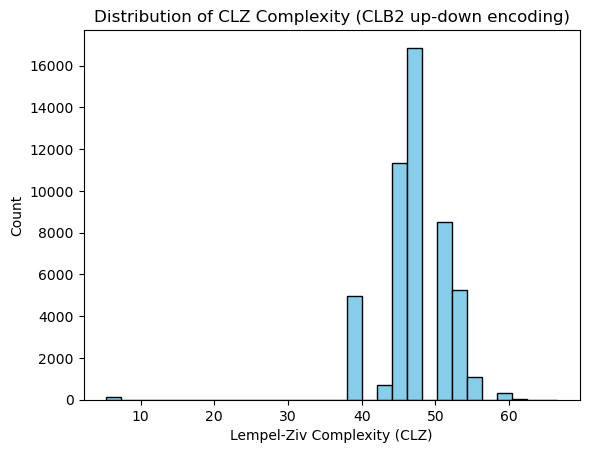

Wildtype phenotype rank: 1093 (frequency: 2)


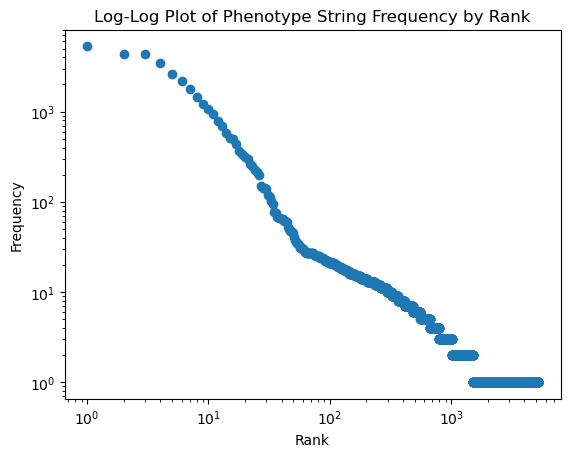

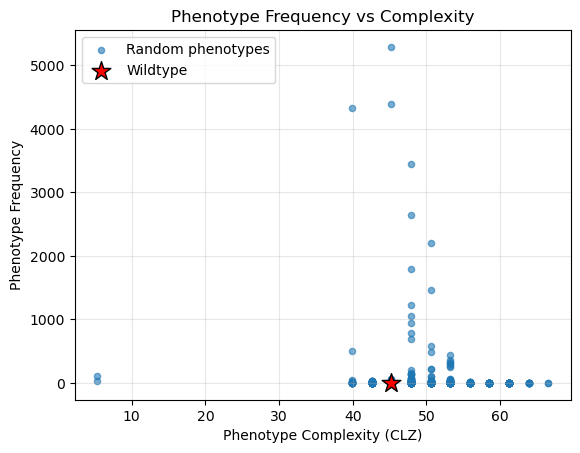

In [21]:
import matplotlib.pyplot as plt
from collections import Counter
import time
from datetime import datetime, timedelta

def print_progress(i, total, start_time, successful_count, skipped_count, interval=0.05):
    """Print progress every 'interval' fraction of total samples"""
    if (i+1) % int(interval * total) == 0:
        elapsed = time.time() - start_time
        progress = (i+1) / total
        eta = datetime.now() + timedelta(seconds=elapsed / progress * (1 - progress))
        print(f"{i+1}/{total} ({progress*100:.1f}%) | success: {successful_count} | skip: {skipped_count} | "
              f"elapsed: {elapsed/60:.1f}m | ETA: {eta.strftime('%H:%M')} ({elapsed/progress*(1-progress)/60:.1f}m left)")

N = 50000
encodings = []
complexities = []
skipped_count = 0
start_time = time.time()

for i in range(N):
    rr = te.loadSBMLModel("/home/gijs/Documents/OxfordEvolution/Yeast/Chen/chen2004_biomd56.xml")
    sample_parameters(rr)
    time_sim, clb2 = simulate_and_extract(rr)

    if time_sim is None or clb2 is None:
        skipped_count += 1
        continue

    encoding = up_down_encoding(time_sim, clb2, nbins=40)
    encodings.append(encoding)
    complexities.append(CLZ(encoding))
    
    print_progress(i, N, start_time, len(encodings), skipped_count)

print(f"\nFinal: {len(encodings)} successful, {skipped_count} skipped")
print("Example encoding:", encodings[0][:120], "...")
print("Mean complexity:", np.mean(complexities))

plt.figure()
plt.hist(complexities, bins=30, color='skyblue', edgecolor='black')
plt.xlabel("Lempel-Ziv Complexity (CLZ)")
plt.ylabel("Count")
plt.title("Distribution of CLZ Complexity (CLB2 up-down encoding)")
plt.show()

# Compute wildtype encoding
rr_wt = te.loadSBMLModel("/home/gijs/Documents/OxfordEvolution/Yeast/Chen/chen2004_biomd56.xml")
sample_parameters(rr_wt, wildtype=True)
time_wt, clb2_wt = simulate_and_extract(rr_wt)
encoding_wt = up_down_encoding(time_wt, clb2_wt, nbins=40)

# Find rank of wildtype phenotype in the sorted frequency list
phenotype_counts = Counter(encodings)
frequencies = sorted(phenotype_counts.values(), reverse=True)
sorted_phenotypes = [k for k, v in sorted(phenotype_counts.items(), key=lambda item: item[1], reverse=True)]

if encoding_wt in sorted_phenotypes:
    wt_rank = sorted_phenotypes.index(encoding_wt) + 1
    wt_freq = phenotype_counts[encoding_wt]
    print(f"Wildtype phenotype rank: {wt_rank} (frequency: {wt_freq})")
else:
    print("Wildtype phenotype not found in sampled set.")

ranks = np.arange(1, len(frequencies) + 1)

plt.figure()
plt.loglog(ranks, frequencies, marker='o', linestyle='none')
plt.xlabel("Rank")
plt.ylabel("Frequency")
plt.title("Log-Log Plot of Phenotype String Frequency by Rank")
plt.show()

# Create scatterplot of phenotype frequency vs complexity
phenotype_complexities = []
phenotype_frequencies = []

for phenotype, frequency in phenotype_counts.items():
    complexity = CLZ(phenotype)
    phenotype_complexities.append(complexity)
    phenotype_frequencies.append(frequency)

plt.figure()
plt.scatter(phenotype_complexities, phenotype_frequencies, alpha=0.6, s=20, label='Random phenotypes')

# Add wildtype point as a star if it exists in the data
if encoding_wt in phenotype_counts:
    wt_complexity = CLZ(encoding_wt)
    wt_frequency = phenotype_counts[encoding_wt]
    plt.scatter(wt_complexity, wt_frequency, marker='*', s=200, color='red', 
                edgecolor='black', linewidth=1, label='Wildtype', zorder=5)

plt.xlabel("Phenotype Complexity (CLZ)")
plt.ylabel("Phenotype Frequency")
plt.title("Phenotype Frequency vs Complexity")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()